# Blood Cell Subtype Classification Part 2: Transfer Learning using a finetuned VGG16 model. 



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications import DenseNet201
from keras.applications import VGG16
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

File ‘blood_cell_images.zip’ already there; not retrieving.



In [5]:
!unzip -nq blood_cell_images.zip

In [4]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


# Loading data

In [6]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (150,150)

In [7]:
def load_data():

    datasets = [ 'blood_cell_images/TRAIN','blood_cell_images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the| img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [9]:
images, labels = load_data()

100%|██████████| 620/620 [00:00<00:00, 668.54it/s]


In [10]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Data Exploration

In [11]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 9955
Number of validation examples: 1245
Number of testing examples: 1244
Training images are of shape: (9955, 150, 150, 3)
Training labels are of shape: (9955,)
Validation images are of shape: (1245, 150, 150, 3)
Validation labels are of shape: (1245,)
Test images are of shape: (1244, 150, 150, 3)
Test labels are of shape: (1244,)


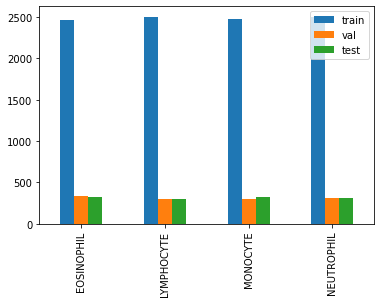

In [12]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

In [ ]:
def display_random_image (class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# Model build and training 

In [13]:


vgg16_model = VGG16(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

# Option here to train on the final Conv5 block in the densenet model ("True") or use imagenet weights for this layer ("False")

vgg16_model.trainable = True

for layer in vgg16_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = False
  else:
    layer.trainable = False

# 3 fully connected layers are added, with 256, 128 and 64 units respectively
# Dropout and Batch Normalization are performed on the fully connected layers.

input = Input(shape = (150,150,3))
layer = vgg16_model(inputs=input)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu')(layer)
layer = Dropout(0.7)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=64, activation='relu')(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=4,activation='softmax')(layer)

model2 = Model(inputs=input, outputs=layer)

model2.summary()

model2.compile(loss='sparse_categorical_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [14]:
# Train model 

history2 = model2.fit(
    train_images, 
    train_labels, 
    batch_size = 16, 
    epochs = 25, 
    validation_data =(val_images, val_labels) , 
    callbacks=[learning_rate_reduction])

Epoch 1/25
623/623 [==============================] - 47s 55ms/step - loss: 1.4538 - accuracy: 0.2959 - val_loss: 1.2688 - val_accuracy: 0.4699 - lr: 0.0010
Epoch 2/25
623/623 [==============================] - 32s 51ms/step - loss: 1.2949 - accuracy: 0.3930 - val_loss: 1.0653 - val_accuracy: 0.5518 - lr: 0.0010
Epoch 3/25
623/623 [==============================] - 32s 51ms/step - loss: 1.1727 - accuracy: 0.4742 - val_loss: 0.9438 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 4/25
623/623 [==============================] - 32s 51ms/step - loss: 1.0740 - accuracy: 0.5363 - val_loss: 0.8310 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 5/25
623/623 [==============================] - 32s 51ms/step - loss: 0.9756 - accuracy: 0.5862 - val_loss: 0.7329 - val_accuracy: 0.6916 - lr: 0.0010
Epoch 6/25
623/623 [==============================] - 32s 51ms/step - loss: 0.9091 - accuracy: 0.6278 - val_loss: 0.7069 - val_accuracy: 0.7060 - lr: 0.0010
Epoch 7/25
623/623 [==============================] - 32s 

# Model Evaluation

In [15]:
# Create Accuracy and Loss chart function

def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(25)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

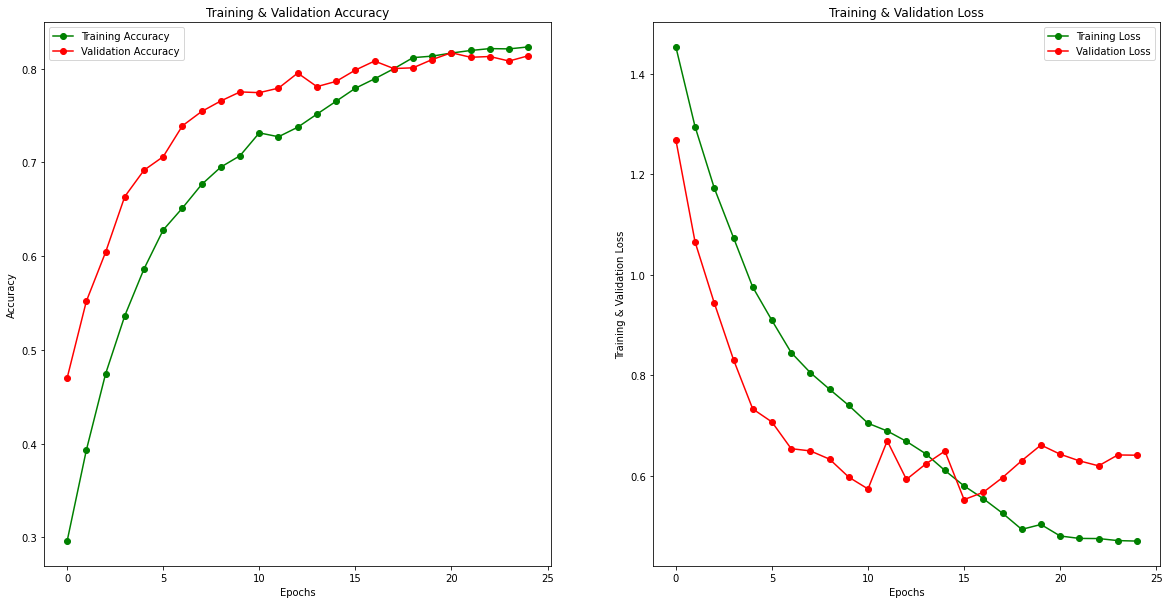

In [16]:
# Accuracy and Loss charts for Model 2

plot_accuracy_loss_chart(history2)

In [18]:
# Save model 

model2.save("vgg16.h5")

In [17]:
# Evaluating the model on the test data

results = model2.evaluate(test_images, test_labels)

print("Loss of the model is - ", results[0])
print("Accuracy of the model is - ", results[1]*100, "%")

39/39 [==============================] - 7s 126ms/step - loss: 0.5909 - accuracy: 0.8191
Loss of the model is -  0.5908626914024353
Accuracy of the model is -  81.9131851196289 %


In [ ]:
# Create predictions for test images

predictions2 = model2.predict(test_images)
predictions2 = np.argmax(predictions2,axis=1)
predictions2[:15]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    test_labels, 
    predictions2, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

In [ ]:
# Confusion matrix plot function and execute 

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    


In [ ]:
# Plot confusion matrix for Model 2

cm2 = confusion_matrix(test_labels, predictions2)
cm2 = pd.DataFrame(cm2, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
plot_confusion_matrix(cm2)